In [58]:
%pylab inline
from lib import price_utils
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
reload(price_utils)
pd.options.display.float_format = '£{:,.2f}'.format


month = '2016-09-01'

Populating the interactive namespace from numpy and matplotlib


# Top ccg-presentation savings

The SQL for this is abstracted into the `price_utils` library, q.v. for details.

We normalise prescriptions to their generic equivalent (where possible), and exclude specials.

The following is sorted by possible savings at the top decile. It tells us that CCG 03C (NHS Leeds West) had the single biggest saving opportunity: to save £13,500 on its purchase of 60 Sucralfate Enemas. It paid £238 per dose, when the lowest decile paid £12 per dose.

In [59]:
top_1000_ccg = price_utils.get_savings(group_by='ccg', month=month, limit=1000)

In [60]:
top_1000_ccg.head()

,bnf_presentation,bnf_chemical,pct,generic_presentation,category,brand_count,lowest_decile,quantity,price_per_dose,possible_savings
0,Influenza_Vac Inact 0.5ml Pfs,Influenza,13T,1404000H0AAAFAF,NP8,4,£5.85,25993,£7.74,"£49,005.16"
1,Fluticasone/Salmeterol_Inh 250/25mcg120D,Fluticasone Propionate (Inh),13P,0302000N0AABGBG,C,3,£44.61,3170,£59.10,"£45,948.30"
2,Glycopyrronium Brom_Inh Cap 55mcg + Dev,Glycopyrronium Bromide,06M,0301020S0AAAAAA,C,2,£0.92,23403,£2.52,"£37,561.61"
3,Fluticasone/Salmeterol_Inh 250/25mcg120D,Fluticasone Propionate (Inh),01H,0302000N0AABGBG,C,3,£44.61,2531,£57.86,"£33,546.72"
4,Fluticasone/Salmeterol_Inh 250/25mcg120D,Fluticasone Propionate (Inh),09G,0302000N0AABGBG,C,3,£44.61,2221,£59.42,"£32,892.44"


How do the savings break down by Tariff Part VIII?

In [61]:
top_1000_ccg.to_csv("ccgs-%s.csv" % month)
top_1000_ccg.groupby('category')['possible_savings'].sum()

category
A      £201,557.28 
C     £6,636,288.03
M      £701,431.14 
NP8   £1,925,890.51
Name: possible_savings, dtype: float64

## Grouped by CCG

The same data as above, but grouped by CCG

In [62]:
len(top_1000_ccg[top_1000_ccg.possible_savings < 0])


0

In [63]:
by_ccg = top_1000_ccg.groupby('pct')['possible_savings'] \
  .agg({'Count': 'count', 'Total savings': 'sum'}).sort_values('Total savings', ascending=False)
by_ccg.head()

,Count,Total savings
pct,,
11J,25,"£301,882.04"
99P,18,"£274,046.34"
13P,19,"£252,649.95"
09G,17,"£203,632.60"
11N,18,"£202,716.24"


In [64]:
by_ccg['Total savings'].sum()

9465166.9587311763

## Just focusing on Rich's CCG

In [65]:
by_ccg.loc('savings_presentations_pct')['99P']

Count               £18.00 
Total savings   £274,046.34
Name: 99P, dtype: float64

In [70]:
reload(price_utils)
asd = price_utils.get_savings(for_entity='99P', month=month, limit=None)

In [71]:
asd.sort_values('possible_savings', ascending=False)

,bnf_presentation,bnf_chemical,pct,generic_presentation,category,brand_count,lowest_decile,quantity,price_per_dose,possible_savings
0,Budesonide/Formoterol Inh B/A 200/6(120D,Budesonide,99P,0302000K0AAAMAM,C,3,£29.97,5042,£36.47,"£32,770.43"
1,Pregabalin_Cap 300mg,Pregabalin,99P,0408010AEAAAGAG,C,3,£0.80,93796,£1.12,"£29,241.90"
2,Pregabalin_Cap 150mg,Pregabalin,99P,0408010AEAAAEAE,C,3,£0.80,89637,£1.11,"£27,266.15"
3,Fluticasone/Salmeterol_Inh 125/25mcg120D,Fluticasone Propionate (Inh),99P,0302000N0AABFBF,C,3,£26.25,3212,£34.60,"£26,836.25"
4,Budesonide/Formoterol Inh B/A 400/12(60D,Budesonide,99P,0302000K0AAAUAU,C,3,£29.97,3815,£36.32,"£24,210.45"
5,Pregabalin_Cap 75mg,Pregabalin,99P,0408010AEAAACAC,C,3,£0.80,81763,£1.09,"£23,295.90"
6,Influenza_Vac Inact 0.5ml Pfs,Influenza,99P,1404000H0AAAFAF,NP8,7,£5.85,35736,£6.43,"£20,707.54"
7,Beclomet Diprop_Inha 100mcg (200 D) CFF,Beclometasone Dipropionate,99P,0302000C0AABFBF,NP8,3,£7.42,5999,£10.77,"£20,108.66"
8,Pregabalin_Cap 50mg,Pregabalin,99P,0408010AEAAABAB,C,3,£0.80,57646,£1.09,"£16,673.08"
9,Methocarbamol_Tab 750mg,Methocarbamol,99P,1002020S0AAABAB,A,2,£0.13,43623,£0.50,"£16,082.10"


In [72]:
# Save it to a cSV

asd.to_csv("99P-full-%s.csv" % month)

# Same thing for practices

In [35]:
top_1000_practice = price_utils.get_savings(group_by='practice',month=month, limit=1000)

In [36]:
top_1000_practice.head()


,bnf_presentation,practice,pct,generic_presentation,category,brand_count,lowest_decile,quantity,price_per_dose,possible_savings
0,Sucralfate_Enem 2g In 50ml,B86030,03C,0107010S0AAAGAG,NP8,1,£12.17,60,£256.50,"£14,659.83"
1,"Dalteparin Sod_Inj 25,000u/ml 0.72ml Pfs",K84055,10Q,0208010L0AAAIAI,NP8,1,£10.16,110,£137.41,"£13,996.85"
2,Sod Phenylbut_Liq Spec 1.25g/5ml,J82034,11A,0908010P0AAAEAE,NP8,1,£1.09,2500,£5.56,"£11,187.72"
3,None,E83638,07M,0908010S0AAACAC,NP8,1,£22.91,400,£49.99,"£10,831.68"
4,Melatonin_Tab 3mg,H82016,09G,0401010ADAABPBP,NP8,2,£0.75,552,£19.26,"£10,219.00"


In [37]:

top_1000_practice.to_csv("practices-%s.csv" % month)

# What is the distribution of the easiest cost savings?

For each practice, compute and sum its top three savings, then plot these in a histogram.

In [61]:
reload(price_utils)
top_10 = price_utils.top_savings_per_entity(top_n=10, entity='practice')

In [62]:
top_10.describe()

,top_savings_sum
count,"£7,637.00"
mean,"£5,535.46"
std,"£4,056.42"
min,£0.00
25%,"£2,647.86"
50%,"£4,593.02"
75%,"£7,467.04"
max,"£65,733.17"


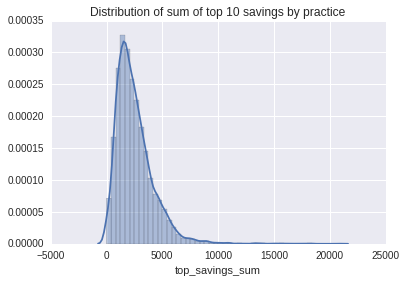

In [40]:
sns.distplot(top_10.top_savings_sum)
plt.title("Distribution of sum of top 10 savings by practice")
plt.show()

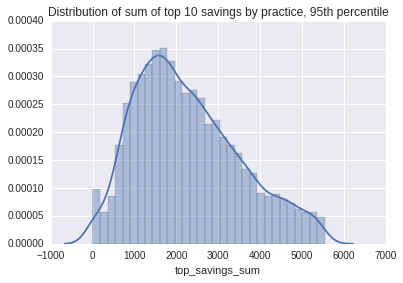

In [41]:
asd = top_10[top_10.top_savings_sum < top_10.top_savings_sum.quantile(.95)]
g = sns.distplot(asd.top_savings_sum)
plt.title("Distribution of sum of top 10 savings by practice, 95th percentile")
plt.show()

In [42]:
top_10_pct = price_utils.top_savings_per_entity(top_n=10, entity='pct')

In [43]:
top_10_pct.describe()

,top_savings_sum
count,£213.00
mean,"£8,115.55"
std,"£3,380.31"
min,£39.53
25%,"£6,055.19"
50%,"£7,508.52"
75%,"£9,312.40"
max,"£22,355.28"


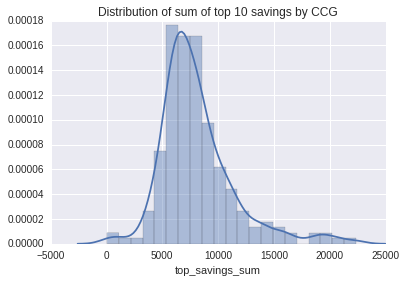

In [44]:
sns.distplot(top_10_pct.top_savings_sum)
plt.title("Distribution of sum of top 10 savings by CCG")
plt.show()

In [51]:
reload(price_utils)
top_1000_product = price_utils.get_savings(group_by='product',month=month, limit=1000)


In [56]:
top_1000_product.head(5)


,bnf_presentation,generic_presentation,category,brand_count,lowest_decile,quantity,price_per_dose,possible_savings
0,Fluticasone/Salmeterol_Inh 250/25mcg120D,0302000N0AABGBG,C,3,£44.61,158950,£56.36,"£1,866,927.90"
1,Pregabalin_Cap 75mg,0408010AEAAACAC,C,5,£0.81,5035691,£1.13,"£1,615,982.91"
2,Influenza_Vac Inact 0.5ml Pfs,1404000H0AAAFAF,NP8,11,£5.85,2055110,£6.62,"£1,588,060.62"
3,Budesonide/Formoterol Inh B/A 200/6(120D,0302000K0AAAMAM,C,3,£29.97,225338,£36.47,"£1,465,282.03"
4,Budesonide/Formoterol Inh B/A 400/12(60D,0302000K0AAAUAU,C,3,£29.97,153858,£36.16,"£952,534.52"


In [55]:
top_10.head(5)

,practice,top_savings_sum
0,A81001,"£2,778.59"
1,A81002,"£7,380.16"
2,A81003,"£1,860.27"
3,A81004,"£2,929.29"
4,A81005,"£2,573.83"


In [107]:
reload(price_utils)
# A list of all the generic presentations in the top three savings for each practice
df = price_utils.all_presentations_in_per_entity_top_n(top_n=3, entity='practice', month='2016-09-01')

In [108]:
# Total savings if each practice enacted its top three savings
df.top_savings_sum.sum()

9971057.6083940677

In [109]:
reload(price_utils)
# A list of all the generic presentations in the top three savings for each practice
df2 = price_utils.all_presentations_in_per_entity_top_n(top_n=1, entity='practice', month='2016-09-01')

In [110]:
df2.top_savings_sum.sum()

4859847.4314697497

In [98]:
# The top savings by presentation if each practice enacted its top three savings
by_presentation = df.groupby('presentation').top_savings_sum.sum().sort_values(inplace=False, ascending=False)
by_presentation.head()

presentation
Influenza_Vac Inact 0.5ml Pfs              £1,253,640.15
Fluticasone/Salmeterol_Inh 250/25mcg120D   £1,236,113.36
Pregabalin_Cap 75mg                         £774,112.50 
Budesonide/Formoterol Inh B/A 200/6(120D    £675,861.01 
Glycopyrronium Brom_Inh Cap 55mcg + Dev     £451,707.71 
Name: top_savings_sum, dtype: float64

In [102]:
# The top savings by chemical if each practice enacted its top three savings
by_subpara = df.groupby('chemical').top_savings_sum.sum().sort_values(inplace=False, ascending=False)
by_subpara.head(10)

chemical
Fluticasone Propionate (Inh)   £1,454,250.86
Influenza                      £1,253,640.15
Budesonide                      £891,834.67 
Pregabalin                      £778,805.21 
Enteral Nutrition               £544,400.95 
Glycopyrronium Bromide          £466,395.99 
Levetiracetam                   £316,636.82 
Lamotrigine                     £280,792.15 
Colecalciferol                  £237,431.06 
Methocarbamol                   £235,738.63 
Name: top_savings_sum, dtype: float64

In [112]:
# The top savings by chemical if each practice enacted its top saving
by_chemical2 = df2.groupby('chemical').top_savings_sum.sum().sort_values(inplace=False, ascending=False)
by_chemical2.head(10)

chemical
Influenza                              £792,511.21
Fluticasone Propionate (Inh)           £643,038.03
Glycopyrronium Bromide                 £334,010.79
Budesonide                             £294,772.05
Enteral Nutrition                      £279,301.00
Pregabalin                             £227,347.99
Methocarbamol                          £147,681.59
Colecalciferol                         £137,151.45
Dalteparin Sodium                      £136,769.04
Co-Proxamol (Dextroprop HCl/Paracet)   £127,297.26
Name: top_savings_sum, dtype: float64

In [114]:
reload(price_utils)
# A list of savings for each generic presentations, if al practices addressed every action that saved at least £50
df3 = price_utils.cost_savings_at_minimum_for_practice(50, month='2016-09-01')

In [122]:
d = {}
for threshold in [10, 110, 210, 310, 410, 510, 610, 710, 810, 910, 1010]:
    d[threshold] = price_utils.cost_savings_at_minimum_for_practice(threshold, month='2016-09-01').top_savings_sum.sum()
d

{10: 39841544.37072815,
 110: 23063336.833109081,
 210: 15391538.835205793,
 310: 10988992.06233073,
 410: 8164705.2583904853,
 510: 6252864.8846674459,
 610: 4924952.9919923218,
 710: 3944961.2480575251,
 810: 3247655.5088338065,
 910: 2720026.2112188255,
 1010: 2347935.886273921}

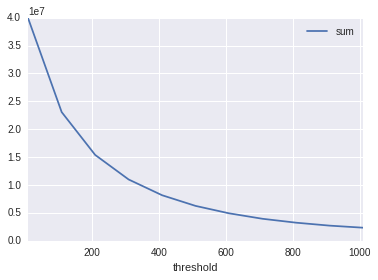

In [155]:
pd.options.display.float_format = None
asd = pd.DataFrame(d.items())
asd.columns = ['threshold', 'sum']
s = asd.sort_values('threshold')
s.plot(x='threshold', y='sum')

In [168]:
reload(price_utils)
s = top_1000_product.head(20)
s['peak_count'] = s['generic_presentation'].apply(lambda x: price_utils.count_peaks(x))

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [165]:
s

,bnf_presentation,pct,generic_presentation,category,brand_count,lowest_decile,quantity,price_per_dose,possible_savings,peak_count
0,Influenza_Vac Inact 0.5ml Pfs,13T,1404000H0AAAFAF,NP8,4,5.850000,25993,7.735321,49005.160000,1
1,Fluticasone/Salmeterol_Inh 250/25mcg120D,13P,0302000N0AABGBG,C,3,44.610000,3170,59.104732,45948.300000,1
2,Glycopyrronium Brom_Inh Cap 55mcg + Dev,06M,0301020S0AAAAAA,C,2,0.916667,23403,2.521658,37561.610000,2
3,Fluticasone/Salmeterol_Inh 250/25mcg120D,01H,0302000N0AABGBG,C,3,44.610000,2531,57.864334,33546.720000,1
4,Fluticasone/Salmeterol_Inh 250/25mcg120D,09G,0302000N0AABGBG,C,3,44.610000,2221,59.419743,32892.440000,1
5,Budesonide/Formoterol Inh B/A 200/6(120D,99P,0302000K0AAAMAM,C,3,29.970000,5042,36.469490,32770.430000,1
6,Fluticasone/Salmeterol_Inh 250/25mcg120D,99P,0302000N0AABGBG,C,3,44.610000,2267,58.765033,32089.460000,1
7,Glycopyrronium Brom_Inh Cap 55mcg + Dev,06L,0301020S0AAAAAA,C,2,0.916667,15690,2.918795,31413.400000,2
8,Glycopyrronium Brom_Inh Cap 55mcg + Dev,03R,0301020S0AAAAAA,C,2,0.916667,2375,14.068421,31235.416667,2
9,Fluticasone/Salmeterol_Inh 250/25mcg120D,02H,0302000N0AABGBG,C,3,44.610000,2051,59.269746,30067.140000,1


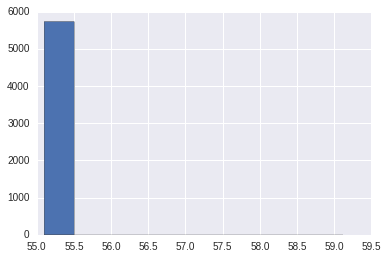

In [167]:
code = "0302000N0AABGBG"

sql = """  SELECT
        *
      FROM
        ebmdatalab.tmp_eu.prescribing_sept
      WHERE
        bnf_code = '%s'""" % code
df = pd.io.gbq.read_gbq(
        sql, project_id="ebmdatalab", verbose=False, dialect='standard')
df['ppq'] = df['actual_cost'] / df['quantity']
df['ppq'].hist()